In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os

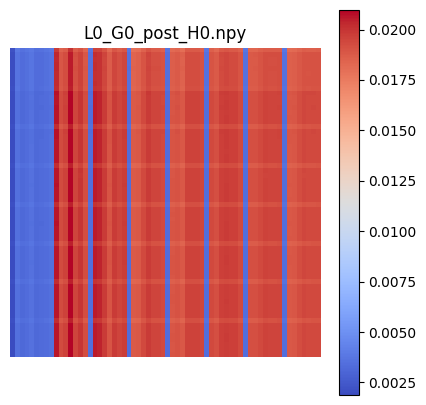

In [ ]:
def show_attention_heatmap(path, title=None):
    attn = np.load(path)

    plt.figure(figsize=(5, 5))
    plt.imshow(attn, cmap="coolwarm")
    plt.colorbar()
    plt.title(title if title else os.path.basename(path))
    plt.axis("off")
    plt.show()

# Example
show_attention_heatmap("attn_mats/nystrom/L0_G0_post_H0.npy")

## Functions

In [12]:
def analyze_rank(attn, eps=1e-3):
    """
    attn: (tokens, tokens) numpy array
    eps: threshold for epsilon-rank
    """
    # SVD
    s = np.linalg.svd(attn, compute_uv=False)

    # ---- 1) epsilon rank (threshold relative to largest singular value)
    eps_rank = np.sum(s > eps * s[0])

    # ---- 2) condition number (ratio)
    cond = s[0] / s[-1] if s[-1] != 0 else np.inf

    # ---- 3) stable rank
    stable_rank = (np.sum(s**2) / (s[0]**2))

    # ---- 4) participation ratio (measure of spread)
    participation_ratio = (np.sum(s)**2) / np.sum(s**2)

    # ---- 5) true rank (machine precision)
    true_rank = np.linalg.matrix_rank(attn)

    return {
        "eps_rank": eps_rank.item(),
        "condition_number": cond.item(),
        "stable_rank": stable_rank.item(),
        "participation_ratio": participation_ratio.item(),
        "true_rank": true_rank.item()
    }

# Example
attn = np.load("attn_mats/original/L0_G0_pre_H0.npy")
analyze_rank(attn)


{'eps_rank': 3,
 'condition_number': 8.630195075656058e+24,
 'stable_rank': 1.000622034072876,
 'participation_ratio': 1.0604966878890991,
 'true_rank': 7}

In [14]:
import numpy as np
import pandas as pd
import glob
import re

def analyze_rank(attn, eps=1e-3):
    s = np.linalg.svd(attn, compute_uv=False)
    cond = s[0] / s[-1] if s[-1] != 0 else np.inf
    eps_rank = np.sum(s > eps * s[0])
    true_rank = np.linalg.matrix_rank(attn)
    return eps_rank, true_rank, cond

def parse_filename(fname):
    """
    Example filename:
    L0_G2_B0_pre_H3.npy  (or without B, depending on your format)
    We extract: L, G, pos, H
    """
    base = fname.split("/")[-1]
    
    # works for formats like:
    # L0_G0_pre_H1.npy
    # L2_G1_post_H5.npy
    m = re.match(r"L(\d+)_G(\d+)_([a-zA-Z]+)_H(\d+)\.npy", base)
    if m:
        L, G, pos, H = m.groups()
        return int(L), int(G), pos, int(H)
    else:
        raise ValueError(f"Filename format not recognized: {fname}")

def build_attention_dataframe(path="attn_mats/original/*.npy"):
    rows = []

    for fname in sorted(glob.glob(path)):
        # parse filename meta-data
        L, G, pos, H = parse_filename(fname)

        # load matrix
        attn = np.load(fname)

        # compute ranks
        eps_rank, true_rank, cond = analyze_rank(attn)

        # append record
        rows.append({
            "Layer": L,
            "Group": G,
            "Head": H,
            "Pos": pos,
            "EpsRank": eps_rank,
            "TrueRank": true_rank,
            # "condition": cond
        })

    df = pd.DataFrame(rows)
    return df

df_attn = build_attention_dataframe()
df_attn.head()

,Layer,Group,Head,Pos,EpsRank,TrueRank
0,0,0,0,mid,58,64
1,0,0,1,mid,63,64
2,0,0,2,mid,38,64
3,0,0,3,mid,64,64
4,0,0,4,mid,64,64


In [15]:
df_attn[['EpsRank', 'TrueRank']].describe()

,EpsRank,TrueRank
count,648.000000,648.000000
mean,44.742284,51.537037
std,21.876284,17.854431
min,1.000000,6.000000
25%,24.000000,30.000000
50%,59.000000,64.000000
75%,62.000000,64.000000
max,64.000000,64.000000


In [16]:
df_attn.groupby("Pos")[["EpsRank", "TrueRank"]].mean()

,EpsRank,TrueRank
Pos,,
mid,56.342593,63.907407
post,60.916667,63.902778
pre,16.967593,26.800926


In [17]:
pivot = pd.pivot_table(
    df_attn,
    values=["EpsRank", "TrueRank"],
    index=["Layer"],
    columns=["Pos"],
    aggfunc="mean"
)
pivot

EpsRank                         TrueRank                      
Pos          mid       post        pre        mid       post        pre
Layer                                                                  
0      59.361111  62.305556   7.666667  63.916667  64.000000  18.416667
1      61.916667  61.138889  21.083333  64.000000  64.000000  29.916667
2      61.305556  62.388889  25.472222  63.972222  63.972222  30.000000
3      60.055556  62.472222  25.416667  63.944444  63.944444  30.000000
4      53.805556  62.027778  17.750000  63.833333  63.944444  30.000000
5      41.611111  55.166667   4.416667  63.777778  63.555556  22.472222

In [82]:
def plot_pivot(pivot):
    pivot_reset = pivot.reset_index()
    bar_width = 0.15
    layers = pivot_reset['Layer']
    x = range(len(layers))

    # Plot bars for each Pos
    for i, pos in enumerate(pivot.columns.levels[1]):  # pos values from pivot
        plt.bar([p + i*bar_width for p in x], pivot_reset[('TrueRank', pos)], width=bar_width, label=f'Pos {pos}')

    # Labels and ticks
    plt.xlabel('Layer')
    plt.ylabel('Mean TrueRank')
    plt.title('Paired Bar Plot of TrueRank by Layer and Pos')
    plt.xticks([p + bar_width*(len(pivot.columns.levels[1])/2) for p in x], layers)
    plt.legend(title='Pos')
    plt.show()

## Visualize

In [72]:
normal = build_attention_dataframe(path="attn_mats/original/*")
nopos = build_attention_dataframe(path="attn_mats/nopos/*")
nystrom = build_attention_dataframe(path="attn_mats/nystrom/*")
pnp = build_attention_dataframe(path="attn_mats/pnp/*")

    Pre Rank (QKt) is very less, with first and last layers having extremely small values like 7, 4
    Mid Rank (Qkt + PB) is huge compared to pre rank, positional bias is the one mainly increasing the rank
    Post Rank (softmax(QKt + PB)) is almost ~64 in every layer showing exponential amplifying the distance between values

In [73]:
pivot = pd.pivot_table(
    normal,
    values=["EpsRank", "TrueRank"],
    index=["Layer"],
    columns=["Pos"],
    aggfunc="mean"
)
pivot

EpsRank                         TrueRank                      
Pos          mid       post        pre        mid       post        pre
Layer                                                                  
0      59.361111  62.305556   7.666667  63.916667  64.000000  18.416667
1      61.916667  61.138889  21.083333  64.000000  64.000000  29.916667
2      61.305556  62.388889  25.472222  63.972222  63.972222  30.000000
3      60.055556  62.472222  25.416667  63.944444  63.944444  30.000000
4      53.805556  62.027778  17.750000  63.833333  63.944444  30.000000
5      41.611111  55.166667   4.416667  63.777778  63.555556  22.472222

model psnr 32.573 ssim 0.875

In [74]:
pivot = pd.pivot_table(
    nopos,
    values=["EpsRank", "TrueRank"],
    index=["Layer"],
    columns=["Pos"],
    aggfunc="mean"
)
pivot

EpsRank                         TrueRank                      
Pos          mid       post        pre        mid       post        pre
Layer                                                                  
0       7.527778  11.500000   7.527778  18.111111  32.527778  18.111111
1      20.555556  36.416667  20.555556  29.888889  60.583333  29.888889
2      25.722222  53.055556  25.722222  30.000000  63.666667  30.000000
3      27.972222  54.166667  27.972222  30.000000  63.805556  30.000000
4      22.000000  52.138889  22.000000  30.000000  63.722222  30.000000
5       5.250000  11.138889   5.250000  23.694444  40.166667  23.694444

model psnr 31.685 ssim 0.859

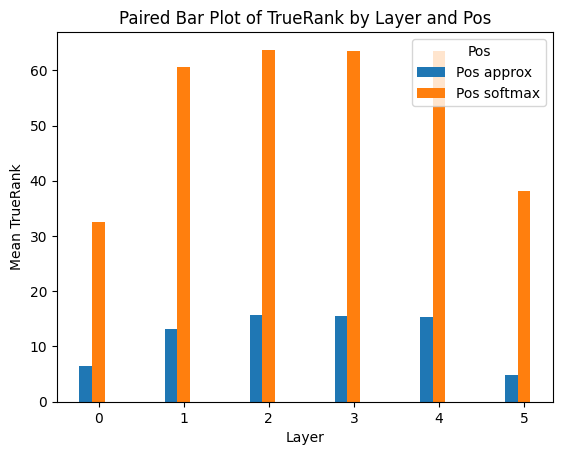

EpsRank              TrueRank           
Pos       approx    softmax     approx    softmax
Layer                                            
0       3.805556  11.805556   6.416667  32.500000
1       9.083333  37.305556  13.250000  60.611111
2      13.361111  53.277778  15.777778  63.722222
3      12.694444  52.944444  15.527778  63.555556
4      12.416667  49.861111  15.416667  63.527778
5       2.166667  10.111111   4.833333  38.166667

In [84]:
pivot = pd.pivot_table(
    nystrom,
    values=["EpsRank", "TrueRank"],
    index=["Layer"],
    columns=["Pos"],
    aggfunc="mean"
)
plot_pivot(pivot)
pivot

psnr 32.454 ssim 0.87279

even though Nystrom is approximation of attention, it is able to get better results than nopos as

softmax(QKt) is approx symmetric matrix, positional bias removes symmeticity, the inverse in nystrom k1 (k2)^-1 k3 also removes it

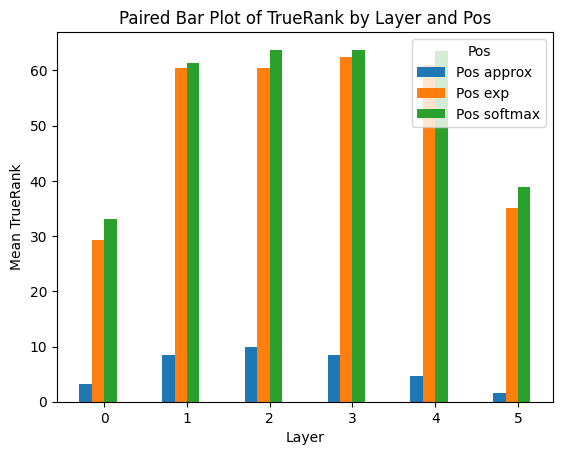

EpsRank                        TrueRank                      
Pos      approx        exp    softmax    approx        exp    softmax
Layer                                                                
0      1.805556   9.805556  12.833333  3.194444  29.333333  33.138889
1      3.555556  33.861111  42.027778  8.527778  60.361111  61.361111
2      4.750000  35.277778  54.333333  9.861111  60.527778  63.638889
3      3.527778  41.694444  53.694444  8.444444  62.416667  63.750000
4      1.972222  34.750000  50.333333  4.611111  60.916667  63.527778
5      1.111111   8.777778  10.250000  1.500000  35.083333  38.861111

In [85]:
pivot = pd.pivot_table(
    pnp,
    values=["EpsRank", "TrueRank"],
    index=["Layer"],
    columns=["Pos"],
    aggfunc="mean"
)
plot_pivot(pivot)
pivot

psnr 32.010 ssim 0.8659

pnp model is over approximationg the kernel comared to nystorm, so it has lower psnr, ssim values

In [78]:
def difference(m0, m1):
    mse = ((m0 - m1)**2).mean()
    mae = (abs(m0 - m1)).mean()
    return mse.item(), mae.item()
m0 = np.load("attn_mats/original/L0_G0_post_H0.npy")
m1 = np.load("attn_mats/pnp/L0_G0_approx_H0.npy")
m2 = np.load("attn_mats/nystrom/L0_G0_approx_H0.npy")

print("nystrom difference:", difference(m0, m2))
print("pnp difference:", difference(m0, m1))

nystrom difference: (9.526251233182847e-06, 0.002186181955039501)
pnp difference: (9.606364983483218e-06, 0.002210804261267185)
